### 1. An introduction to Models in Pyro

A very simple example for modeling
- https://www.infoq.cn/article/8-D5SuBqeBUPr2QLLTX4

In [0]:
!pip install pyro-ppl

In [0]:
# colab packages install
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

In [0]:
pyro.set_rng_seed(101)

### Primitive Stochastic Functions

In [11]:
# Pyro uses PyTorch’s distribution library
# You can also create custom distributions using transforms

loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

sample tensor(-1.3905)
log prob tensor(-1.8857)


### A Simple Model

- Let’s suppose we have a bunch of data with daily mean temperatures and cloud cover. 
- We want to reason about how temperature interacts with whether it was sunny or cloudy. 
- A simple stochastic function that describes how that data might have been generated is given by:

In [12]:
# definition depends on pytorch only
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    # define a binary random variable ‘cloudy’
    # convert the value cloudy to a string
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()
  
weather()

('cloudy', 46.847618103027344)

In [13]:
# The pyro.sample Primitive
# replace the torch.distributions with pyro.distributions 
# and the .sample() and .rsample() calls with calls to pyro.sample
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

tensor(0.9544)
('sunny', 94.37557983398438)
('sunny', 72.5186767578125)
('cloudy', 54.18292999267578)


### Universality: Stochastic Recursion, Higher-order Stochastic Functions, and Random Control Flow

In [14]:
# another function that may help simulate ice cream sales
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

ice_cream_sales()

tensor(220.6519)

In [18]:
# define a geometric distribution that 
# counts the number of failures until the first success
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)

print(geometric(0.5))

2


In [29]:
# define stochastic functions that accept as input or produce as output other stochastic functions
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    y = z1 * z2
    return y

# Lambda operations
# pyro_linear_fn = lambda x: pyro.module("linear", linear)(x)
# define a variable that can plug in the function
def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(1.))

tensor(-0.0422)


### 2. An introduction to Inference in Pyro

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

### A simple model
- model with a guess based on some prior knowledge about the object:
  - weight|guess∼Normal(guess,1)
  - measurement|guess,weight∼Normal(weight,0.75)


In [0]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

- Suppose we want to sample from the distribution of weight given input guess = 8.5, but now we have observed that measurement == 9.5. That is, we wish to infer the distribution: (weight|guess,measurement=9.5)∼?
- Pyro provides the function pyro.condition to allow us to constrain the values of sample statements.
  - pyro.condition is a higher-order function that takes a model and a dictionary of observations and returns a new model that has the same input and output signatures but always uses the given values at observed sample statements:

In [63]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)
  
conditioned_scale

<function pyro.poutine.messenger.Messenger.__call__.<locals>._wraps>

In [53]:
import warnings
warnings.filterwarnings("ignore")

def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    print(weight)
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1.), obs=10.5)
  
scale_obs(8.5)

tensor(7.7602)


10.5

### Flexible Approximate Inference With Guide Functions
- Inference algorithms in Pyro, such as pyro.infer.SVI, allow us to use arbitrary stochastic functions, which we will call guide functions or guides, as approximate posterior distributions.
- use Pyro’s approximate inference algorithms to estimate the distribution over weight given guess and measurement == data
- call guide functions or guides, as approximate posterior distributions. 
  - Guide functions must satisfy these two criteria to be valid approximations for a particular model:
    - 1. all unobserved (i.e., not conditioned) sample statements that appear in the model appear in the guide. 
    - 2. the guide has the same input signature as the model (i.e., takes the same arguments)

In [57]:
#  it turns out that the true posterior distribution over weight 
# given guess and measurement is actually Normal(9.14,0.6)
def perfect_guide(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))
  
perfect_guide(8.5)

tensor(9.1667)

### Parametrized Stochastic Functions and Variational Inference
- use the top-level function pyro.param to specify a family of guides indexed by named parameters, and search for the member of that family that is the best approximation according to some loss function. This approach to approximate posterior inference is called variational inference.
- Pyro training
  - Parameters are always real-valued tensors
  -  We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide
  - We use stochastic gradient descent to search for the optimal parameters.

In [0]:
# parametrize a and b in scale_posterior_guide instead of specifying them by hand
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))
  
from torch.distributions import constraints
# use constraints to force variables to satisfy model condition
def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

### Pyro SVI simple example

a =  9.149941444396973
b =  0.6199020147323608


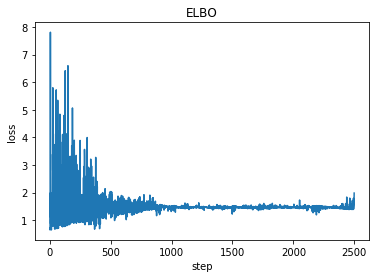

In [60]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

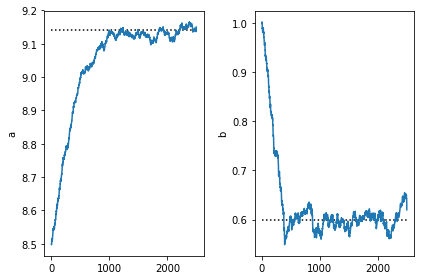

In [64]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()